# NCGM Once Again

We've fitted some curves and confirmed that neural nets actually work. Now, we're going to try to solve the NCGM again.

## The Set-Up
Once again, the problem is 
$$
\begin{align*}
    V(k,z) & = \max_{k'}\frac{(zk^{\alpha} + (1-\delta)k - k')^{1-\sigma}}{1-\sigma} + \beta \sum_{z'}P(z'|z)V(k',z').
\end{align*}
$$

In our case, $z\in\{z_l,z_h\}$ and follows a Markov transition matrix with $P(z_h|z_h) = p$ and $P(z_l|z_l) = q$. For our purposes, we're going to choose $z_l = 1$, $z_h = 1.5$, $\alpha = 0.3$, $\beta = 0.96$, $\delta = 0.1$, $\sigma = 2$, $p = 0.7$, and $q = 0.6$.

## Warm-Up: Use EGM to Solve It

As a warm-up, we're going to solve this using EGM.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import jit
from jax import lax, random, numpy as jnp

In [2]:
alp0, bet0, del0, ppp0, qqq0, sig0, zlo0, zhi0 = 0.3, 0.96, 0.1, 0.7, 0.6, 2.0, 1.0, 1.5
ss_kap     = alp0 * (zlo0 + (zhi0 - zlo0) * (1.0 - qqq0) / (2.0 - ppp0 - qqq0))
ss_kap    /= (1.0 / bet0 - (1.0 - del0))
ss_kap     = ss_kap ** (1.0 / (1.0 - alp0))
pi_mat   = np.array([[ppp0, 1.0 - ppp0], [1.0 - qqq0, qqq0]]).T
num_sims = 1000
kap = np.linspace(0.1, 15, num_sims)

In [3]:
def egm_ncgm(kgrid, max_its = 1000, tol = 1e-8):
    kp0 = np.zeros((len(kgrid), 2))
    ic0 = np.zeros((len(kgrid), 2))
    rts = np.zeros((len(kgrid), 2))
    kgs = np.concatenate((kgrid[:,np.newaxis], kgrid[:,np.newaxis]), axis = 1)
    ic0 = (kgs ** alp0) * np.array((zhi0, zlo0)) + (1.0 - del0) * kgs
    rts = alp0 * (kgs ** (alp0 - 1.0)) * np.array((zhi0, zlo0)) + (1.0 - del0)
    kp0 =  0.05 * ic0
    for i in range(max_its):
        cg   = bet0 * (ic0 - kp0) ** (-sig0) * rts
        cg   = (cg @ pi_mat) ** (-1.0 / sig0)
        cohg = cg + kgs
        kpnew = np.zeros_like(kp0)
        kpnew[:,0] = np.interp(ic0[:,0], cohg[:,0], kgrid)
        kpnew[:,1] = np.interp(ic0[:,1], cohg[:,1], kgrid)
        kp1 = np.maximum(kpnew, kgrid[0])
        dev = np.max(np.abs(kp1 - kp0))
        if dev < tol:
            print(dev)
            print(i)
            return kp1
        kp0 = kp1
    print("Warning! Maximum Number of Iterations Reached!")
    return kp0

In [4]:
egm_sol = egm_ncgm(kap)

8.959458952517707e-09
114


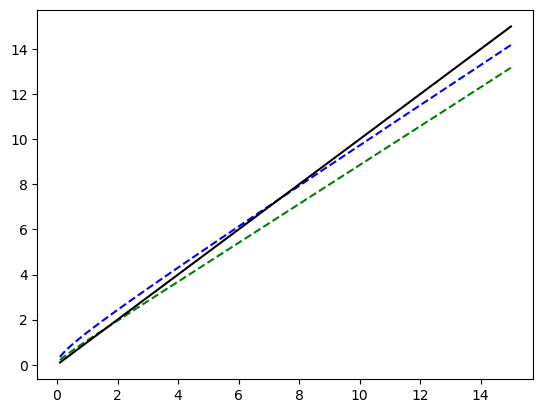

In [5]:
plt.plot(kap, egm_sol[:,1], 'g--')
plt.plot(kap, egm_sol[:,0], 'b--')
plt.plot(kap, kap, 'k')

## Use Neural Nets to Solve It

First, we import some packages.

In [6]:
import jax
import jaxopt
from optax import sgd, adam, adabelief, apply_updates
from typing import Any, Callable, Sequence
from jax import grad, value_and_grad
from flax.core import freeze, unfreeze
from flax import linen as nn

### Define and Initialize the Neural Net

In [7]:
class ExplicitMLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        self.layers = [nn.Dense(feat) for feat in self.features]
        
    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.sigmoid(x)
        return x

In [8]:
key1, key2 = random.split(random.PRNGKey(8675309), 2)
x = random.uniform(key1, (4,2))

In [9]:
g_inner = ExplicitMLP(features=[8,8,1])

params = g_inner.init(key2, x)

print('initialized parameter shapes:\n', jax.tree_util.tree_map(jnp.shape, unfreeze(params)))

initialized parameter shapes:
 {'params': {'layers_0': {'bias': (8,), 'kernel': (2, 8)}, 'layers_1': {'bias': (8,), 'kernel': (8, 8)}, 'layers_2': {'bias': (1,), 'kernel': (8, 1)}}}


### Wrap the Network to Get Policy Function

In [10]:
@jit
def g_approx(params, x):
    inner_g = nn.sigmoid(g_inner.apply(params, x))
    income  = x[:,1] * x[:,0] ** alp0 + (1.0 - del0) * x[:,0]
    return inner_g * income[:,jnp.newaxis]

In [11]:
%time g2_1 = g_approx(params, np.concatenate((kap[:,np.newaxis],np.ones((len(kap),1))), axis = 1))
%time g2_15 = g_approx(params, np.concatenate((kap[:,np.newaxis], 1.5 * np.ones((len(kap),1))), axis = 1))

CPU times: user 57.4 ms, sys: 3.83 ms, total: 61.3 ms
Wall time: 45.1 ms
CPU times: user 168 μs, sys: 28 μs, total: 196 μs
Wall time: 210 μs


Now, see what it looks like at the beginning.

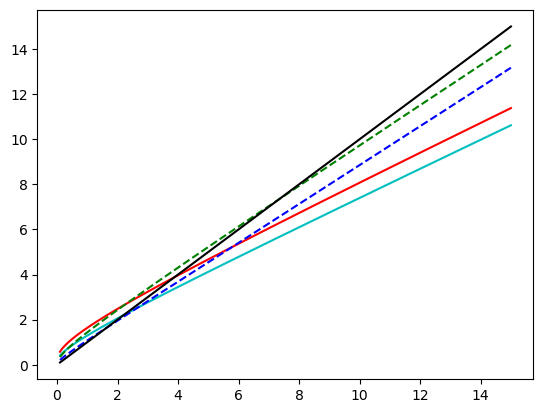

In [12]:
plt.plot(kap, g2_1[:,0],'c')
plt.plot(kap, g2_15[:,0],'r')
plt.plot(kap, egm_sol[:,0],'g--')
plt.plot(kap, egm_sol[:,1],'b--')
plt.plot(kap, kap, 'k')

### Define the Loss Function

In [13]:
@jit
def our_loss(params):
    # draw (k, z) from set and form into matrix 'xs' 
    ks = np.random.uniform(1.0, 10.0, (num_sims, 1))
    zs = np.random.binomial(1, 0.5, (num_sims, 1))
    ps = (1.0 - qqq0) * np.ones((num_sims, 1)) + (ppp0 + qqq0 - 1) * zs
    zs = zlo0 + (zhi0 - zlo0) * zs
    xs = np.concatenate((ks, zs), axis = 1)
    
    # compute k' and c
    kp = g_approx(params, xs)
    c0 = zs * ks ** alp0 + (1.0 - del0) * ks - kp
    
    # compute k'' and c' for both realizations of z'
    kpph = g_approx(params, jnp.concatenate((kp, zhi0 * jnp.ones((num_sims, 1))), axis = 1))
    kppl = g_approx(params, jnp.concatenate((kp, zlo0 * jnp.ones((num_sims, 1))), axis = 1))
    cph  = zhi0 * kp ** alp0 + (1.0 - del0) * kp - kpph
    cpl  = zlo0 * kp ** alp0 + (1.0 - del0) * kp - kppl
    
    # compute r' for both realizations of z'
    rh = alp0 * zhi0 * kp ** (alp0 - 1.0) + (1.0 - del0)
    rl = alp0 * zlo0 * kp ** (alp0 - 1.0) + (1.0 - del0)
    
    # compute expectation of future
    efut = (bet0 * (ps * rh * cph ** (-sig0) + (1.0 - ps) * rl * cpl ** (-sig0))) ** (-1.0 / sig0)
    
    return jnp.sqrt(jnp.mean((c0 - efut) ** 2.0))

In [14]:
%time our_loss(params)

CPU times: user 120 ms, sys: 47.3 ms, total: 167 ms
Wall time: 97.4 ms


Array(0.33304057, dtype=float32)

### Defining the Optimization Algorithm and Fitting

In [15]:
tx = adam(learning_rate=1e-3)
opt_state = tx.init(params)
loss_grad_fn = jit(value_and_grad(our_loss, 0))
ud = jit(tx.update)
apply_updatesj = jit(apply_updates)

In [16]:
for i in range(40001):
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = ud(grads, opt_state)
    params = apply_updatesj(params, updates)
    if i % 5000 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  0.33304057
Loss step 5000:  0.00020413935
Loss step 10000:  0.00013386073
Loss step 15000:  0.00010992181
Loss step 20000:  9.2925744e-05
Loss step 25000:  8.377614e-05
Loss step 30000:  7.954556e-05
Loss step 35000:  7.679293e-05
Loss step 40000:  7.4809745e-05


### Checking Fit at the End

In [17]:
%time g2_1 = g_approx(params, np.concatenate((kap[:,np.newaxis],np.ones((len(kap),1))), axis = 1))
%time g2_15 = g_approx(params, np.concatenate((kap[:,np.newaxis], 1.5 * np.ones((len(kap),1))), axis = 1))

CPU times: user 953 μs, sys: 615 μs, total: 1.57 ms
Wall time: 840 μs
CPU times: user 807 μs, sys: 525 μs, total: 1.33 ms
Wall time: 722 μs


Now, see what it looks like at the end.

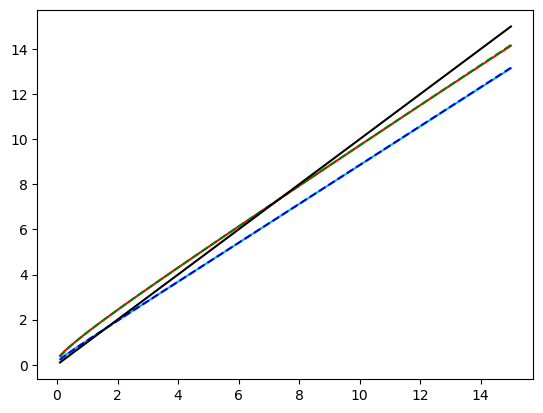

In [18]:
plt.plot(kap, g2_1[:,0],'c')
plt.plot(kap, g2_15[:,0],'r')
plt.plot(kap, egm_sol[:,0],'g--')
plt.plot(kap, egm_sol[:,1],'b--')
plt.plot(kap, kap,'k')